In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
pip install tensorflow keras numpy matplotlib


Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [5]:
# Image size for MobileNetV2 input layer
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
# Load train and test datasets
train_data = train_datagen.flow_from_directory(
  'C:\\birdclassifier\\extracted_dataset\\Train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    'C:\\birdclassifier\\extracted_dataset\\Test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


# Get the number of classes (species)
num_classes = len(train_data.class_indices)
print(f"Number of bird species: {num_classes}")


Found 9414 images belonging to 200 classes.
Found 2374 images belonging to 200 classes.
Number of bird species: 200


In [6]:
# Load pre-trained MobileNetV2 and exclude top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to avoid updating the pre-trained weights
base_model.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pool the output from MobileNetV2
x = Dense(1024, activation='relu')(x)  # Add a dense layer
x = Dense(512, activation='relu')(x)   # Add another dense layer
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)


In [7]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
EPOCHS = 20

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=EPOCHS,
    steps_per_epoch=train_data.n // BATCH_SIZE,
    validation_steps=test_data.n // BATCH_SIZE
)


Epoch 1/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1128s 4s/step - accuracy: 0.5538 - loss: 1.6077 - val_accuracy: 0.4738 - val_loss: 1.9338
Epoch 2/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5312 - loss: 1.6005 - val_accuracy: 0.3333 - val_loss: 2.0176
Epoch 3/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1042s 4s/step - accuracy: 0.6716 - loss: 1.1444 - val_accuracy: 0.5228 - val_loss: 1.7666
Epoch 4/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6250 - loss: 1.3251 - val_accuracy: 0.3333 - val_loss: 1.2921
Epoch 5/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 2162s 7s/step - accuracy: 0.7615 - loss: 0.8284 - val_accuracy: 0.5418 - val_loss: 1.7252
Epoch 6/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7188 - loss: 0.7646 - val_accuracy: 0.1667 - val_loss: 2.1484
Epoch 7/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 870s 3s/step - accuracy: 0.8021 - loss: 0.6824 - val_accuracy: 0.5739 - val_loss: 1.6006
Epoch 8/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 887us/step - accuracy: 0.6875 - loss: 0.8309 - val_acc

In [11]:
# Unfreeze some layers in the base model for fine-tuning
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),  # Use a smaller learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10,  # Fine-tuning for fewer epochs
    steps_per_epoch=train_data.n // BATCH_SIZE,
    validation_steps=test_data.n // BATCH_SIZE
)


Epoch 1/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 920s 3s/step - accuracy: 0.9161 - loss: 0.2608 - val_accuracy: 0.6461 - val_loss: 1.4875
Epoch 2/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8750 - loss: 0.3058 - val_accuracy: 0.8333 - val_loss: 0.7537
Epoch 3/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 927s 3s/step - accuracy: 0.9309 - loss: 0.2330 - val_accuracy: 0.6402 - val_loss: 1.5612
Epoch 4/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9375 - loss: 0.2298 - val_accuracy: 0.6667 - val_loss: 0.5158
Epoch 5/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 874s 3s/step - accuracy: 0.9378 - loss: 0.1960 - val_accuracy: 0.6630 - val_loss: 1.5392
Epoch 6/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9688 - loss: 0.1300 - val_accuracy: 0.8333 - val_loss: 0.8977
Epoch 7/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 1009s 3s/step - accuracy: 0.9476 - loss: 0.1773 - val_accuracy: 0.6605 - val_loss: 1.6031
Epoch 8/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9688 - loss: 0.2391 - val_accurac

In [12]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test accuracy: {test_acc * 100:.2f}%")


75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 581ms/step - accuracy: 0.6391 - loss: 1.6486
Test accuracy: 64.53%


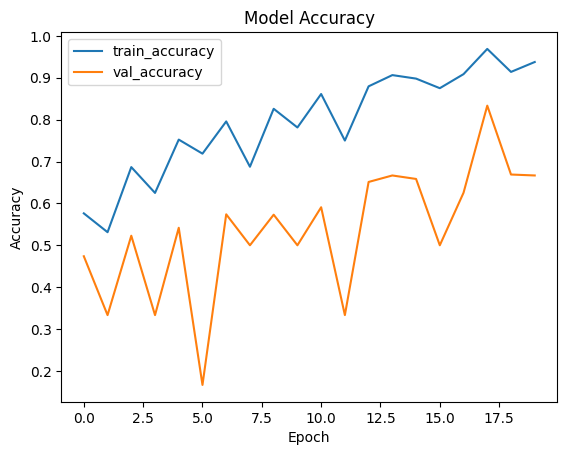

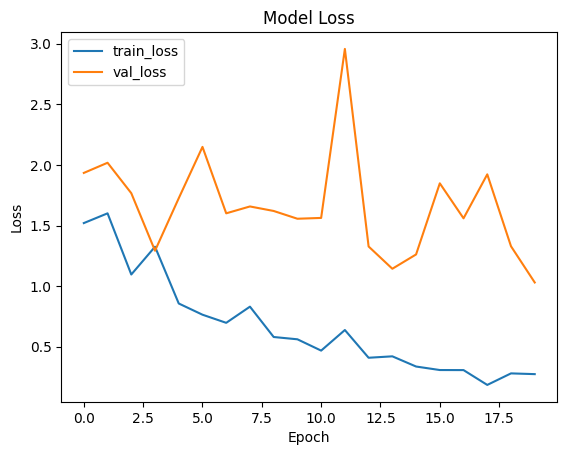

In [13]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [14]:
model.save('bird_species_classifier.h5')
